In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from models.HEGNN import HEGNN  
from rdkit.Chem import rdMolTransforms
#If using earlier than python3.9 version
from typing import Tuple, List


In [40]:
# Load the data
train_df = pd.read_csv('Processed/Combined_Training.txt', sep = '\t')
val_df = pd.read_csv('Processed/Combined_Validate.txt', sep = '\t')
test_df =pd.read_csv('Processed/Combined_Test.txt', sep = '\t')

# While testing, only use the first 500 samples
# train_df = train_df.iloc[:500]
# val_df = val_df.iloc[:500]
# test_df = test_df.iloc[:500]


In [41]:
def balance_datasets(dataframe: pd.DataFrame) -> pd.DataFrame:

    """
    This filters the dataset to have a X:1 ratio of 0 value mols to 1 value mols
    Args:
        dataframe (pd.DataFrame): the dataset dataframe
    Return:
        pd.DataFrame: the filtered dataframe
    
    """
    function_one_df = dataframe[dataframe['Function'] == 1]
    function_zero_df = dataframe[dataframe['Function'] == 0]

    num_function_one = function_one_df.shape[0]

    # Calculate the number of rows to take from 'Function' == 0 (X:1 ratio)
    num_function_zero = min(1 * num_function_one, function_zero_df.shape[0]) #2* 

    balanced_function_zero_df = function_zero_df.sample(n=num_function_zero, random_state=42)
    balanced_train_df = pd.concat([function_one_df, balanced_function_zero_df])

    return balanced_train_df

In [42]:
train_df = balance_datasets(train_df)
val_df = balance_datasets(val_df)
test_df = balance_datasets(test_df)

In [43]:
torch.manual_seed(42)
np.random.seed(42)

In [44]:
map_element_to_one_hot = {
        1: 0, #hydrogen
        6: 1, #carbon
        7: 2, #nitrogen
        9: 3, #fluorine
        5: 4, #boron
        15: 5, #phosphorous
        8: 6, #oxygen
        17: 7, #chlorine
        16: 8, #sulfur
        35: 9, #bromine
        13: 10, #aluminium
        33: 11, #arsenic
        53: 12, #iodine
        80: 13, #mercury
        14: 14, #silicon
        50: 15, #tin
        83: 16, #bismuth
    }

#inverts map_element_to_one_hot
map_one_hot_to_element = {value: key for key, value in map_element_to_one_hot.items()}



In [45]:
def encode_atomic_number(atomic_number: int) -> list:
    """
    Encodes the atomic number into one-hot encoding
    Note: Should we be including hydrogen? that can only form one bond
    """
    # element_mapping = {
    #     1: 0, #hydrogen
    #     6: 1, #carbon
    #     7: 2, #nitrogen
    #     9: 3, #fluorine
    #     5: 4, #boron
    #     15: 5, #phosphorous
    #     8: 6, #oxygen
    #     17: 7, #chlorine
    #     16: 8, #sulfur
    #     35: 9, #bromine
    #     13: 10, #aluminium
    #     33: 11, #arsenic
    #     53: 12, #iodine
    #     80: 13, #mercury
    #     14: 14, #silicon
    #     50: 15, #tin
    #     83: 16, #bismuth
        
    # }

    element_index = map_element_to_one_hot[atomic_number]
    vector_length = len(map_element_to_one_hot.keys())
    one_hot_encoding = [0 for i in range(vector_length)]
    one_hot_encoding[element_index] = 1
    return one_hot_encoding #, vector_length

In [56]:
from tqdm import tqdm
class MoleculeDataset(Dataset):
    """
    Custom Dataset for molecule data.

    Args:
        dataframe (pd.DataFrame): DataFrame containing molecule data.
    """
    def __init__(self, dataframe: pd.DataFrame):
        self.data_list = []
        #self.smiles = None
        for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
            smiles = row['SMILE']
            label = row['Function']
            try:
                mol = Chem.MolFromSmiles(smiles)
            except:
                mol = None
                print(f'Failed to process SMILES: {smiles}')
            if mol is None:
                continue
            data = mol_to_graph_data(mol, smiles)
            if data is None:
                print("Data was None")
                continue
            data.y = torch.tensor([label], dtype=torch.float)
            self.data_list.append(data)

    def __len__(self) -> int:
        return len(self.data_list)

    def __getitem__(self, idx: int):
        return self.data_list[idx]

def atom_features(atom):
    """
    Returns a list of atom features.

    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        List[float]: List of features.
    """
    features = []
    atomic_number = atom.GetAtomicNum()
    atomic_number_encoded = encode_atomic_number(atomic_number)
    for val in atomic_number_encoded:
        features.append(val)
    #features.append(atom.GetAtomicNum())
    features.append(atom.GetDegree())
    features.append(atom.GetFormalCharge())
    features.append(atom.GetNumRadicalElectrons())
    features.append(int(atom.GetHybridization()))
    features.append(int(atom.GetIsAromatic()))
    features.append(atom.IsInRing())
    features.append(atom.GetMass())
    # New features
    features.append(get_atomic_radius(atom))    # Atomic radius
    features.append(get_vdw_radius(atom))       # van der Waals radius
    features.append(get_chirality(atom))# Chirality (0, 1, 2)
    features.append(get_electronegativity(atom)) # EN
    return features 


def get_atomic_radius(atom):
    """
    Returns the covalent radius (approximation) of an atom.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        float: Covalent radius in Ångstroms.
    """
    covalent_radii = {
        1: 0.31, 6: 0.76, 7: 0.71, 8: 0.66, 9: 0.57, 15: 1.07,
        16: 1.05, 17: 0.99, 35: 1.14, 53: 1.33  # Add more elements as needed
    }
    return covalent_radii.get(atom.GetAtomicNum(), 0.7)  # Default to 0.7 Å

def get_vdw_radius(atom):
    """
    Returns the van der Waals radius (approximation) of an atom.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        float: van der Waals radius in Ångstroms.
    """
    vdw_radii = {
        1: 1.2, 6: 1.7, 7: 1.55, 8: 1.52, 9: 1.47, 15: 1.8, 
        16: 1.8, 17: 1.75, 35: 1.85, 53: 1.98  # Add more elements as needed
    }
    return vdw_radii.get(atom.GetAtomicNum(), 1.5)  # Default to 1.5 Å


def get_valence_electrons(atom):
    """
    Returns the number of valence electrons for an atom.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        int: Number of valence electrons.
    """
    valence_electrons = {
        1: 1, 6: 4, 7: 5, 8: 6, 9: 7,
        15: 5, 16: 6, 17: 7, 35: 7, 53: 7
    }
    return valence_electrons.get(atom.GetAtomicNum(), 0)

def get_electronegativity(atom):
    """
    Returns the electronegativity of an atom.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        float: Electronegativity value.
    """
    electronegativity = {
        1: 2.20, 6: 2.55, 7: 3.04, 8: 3.44, 9: 3.98,
        15: 2.19, 16: 2.58, 17: 3.16, 35: 2.96, 53: 2.66
    }
    return electronegativity.get(atom.GetAtomicNum(), 2.0)

def get_chirality(atom):
    """
    Returns the chirality of an atom as a numeric feature.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        int: Chirality encoded as an integer (0: Unspecified, 1: CW, 2: CCW).
    """
    chiral_tag = atom.GetChiralTag()
    if chiral_tag == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
        return 1
    elif chiral_tag == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
        return 2
    else:
        return 0  # Unspecified or no chirality



# Function to check molecule validity
def is_valid_molecule(mol):
    """Sanity check for molecule validity after adding hydrogens."""
    try:
        Chem.SanitizeMol(mol)
        return True
    except Exception as e:
        print(f"Sanitization failed: {e}")
        return False


# Function to convert bond types to numeric values 
def bond_type_to_numeric(bond_type): 
     bond_mapping = {'SINGLE': 0, 'DOUBLE': 1, 'TRIPLE': 2, 'AROMATIC': 3} 
     return bond_mapping.get(bond_type, -1) 


# Function to calculate bond angles 
def calc_bond_angle(mol, atom1_idx, atom2_idx): 
     neighbors1 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom1_idx).GetNeighbors() if nbr.GetIdx() != atom2_idx] 
     neighbors2 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom2_idx).GetNeighbors() if nbr.GetIdx() != atom1_idx] 
     if neighbors1 and neighbors2: 
         return rdMolTransforms.GetAngleDeg(mol.GetConformer(), neighbors1[0], atom1_idx, atom2_idx)
     return None 


# Function to check if a bond is rotatable 
def is_rotatable_bond(bond): 
     if bond.GetBondType() != Chem.rdchem.BondType.SINGLE:
         return False 
     return (not bond.GetBeginAtom().IsInRing() and bond.GetBeginAtom().GetDegree() > 1 and 
             not bond.GetEndAtom().IsInRing() and bond.GetEndAtom().GetDegree() > 1)


# Conformer generation with fallback 
def generate_conformer(mol, max_attempts=1000): 
     params = AllChem.ETKDG()
     params.maxAttempts = max_attempts
     try: 
         success = AllChem.EmbedMolecule(mol, params)
         if success == -1: 
             return None  # Failed to generate conformer 
         try: 
             AllChem.UFFOptimizeMolecule(mol) 
         except ValueError: 
             if not AllChem.MMFFOptimizeMolecule(mol): 
                 return None 
     except Exception as e: 
         print(f'Conformer generation error: {e}') 
         return None 
     return mol 

def calc_bond_length(mol, atom1_idx, atom2_idx):
    """
    Calculates the bond length (3D distance) between two atoms.
    Args:
        mol (Chem.Mol): RDKit molecule object.
        atom1_idx (int): Index of the first atom.
        atom2_idx (int): Index of the second atom.

    Returns:
        float: Bond length in Ångstroms.
    """
    pos1 = mol.GetConformer().GetAtomPosition(atom1_idx)
    pos2 = mol.GetConformer().GetAtomPosition(atom2_idx)
    return pos1.Distance(pos2)

def calc_bond_polarity(atom1, atom2):
    """
    Calculates the bond polarity based on the electronegativity difference.
    Args:
        atom1 (Chem.Atom): First atom.
        atom2 (Chem.Atom): Second atom.

    Returns:
        float: Bond polarity (absolute electronegativity difference).
    """
    electronegativity = {
        1: 2.20, 6: 2.55, 7: 3.04, 8: 3.44, 9: 3.98,
        15: 2.19, 16: 2.58, 17: 3.16, 35: 2.96, 53: 2.66
    }
    en1 = electronegativity.get(atom1.GetAtomicNum(), 2.0)
    en2 = electronegativity.get(atom2.GetAtomicNum(), 2.0)
    return abs(en1 - en2)

def is_bond_in_ring(bond):
    """
    Checks if a bond is part of a ring.
    Args:
        bond (Chem.Bond): RDKit bond object.

    Returns:
        bool: True if the bond is in a ring, False otherwise.
    """
    return bond.IsInRing()

def is_bond_conjugated(bond):
    """
    Checks if a bond is conjugated.
    Args:
        bond (Chem.Bond): RDKit bond object.

    Returns:
        bool: True if the bond is conjugated, False otherwise.
    """
    return bond.GetIsConjugated()

def get_bond_stereochemistry(bond):
    """
    Retrieves the stereochemistry of a bond.
    Args:
        bond (Chem.Bond): RDKit bond object.

    Returns:
        int: 0 if no stereochemistry, 1 for cis, 2 for trans.
    """
    stereo = bond.GetStereo()
    if stereo == Chem.rdchem.BondStereo.STEREOCIS:
        return 1
    elif stereo == Chem.rdchem.BondStereo.STEREOTRANS:
        return 2
    return 0


def mol_to_graph_data(mol: Chem.Mol, smiles_name) -> Data:
    """
    Converts an RDKit Mol object to a PyTorch Geometric Data object.

    Args:
        mol (Chem.Mol): RDKit molecule object.

    Returns:
        data (Data): PyTorch Geometric Data object.
    """
    # Add hydrogens and generate 3D coordinates
    mol = Chem.AddHs(mol)
    if not is_valid_molecule(mol):  # Validate molecule after adding Hs
        print(f"Invalid molecule after adding hydrogens: {smiles_name}")
        return None
    
    mol = generate_conformer(mol)
    if mol is None:
        return None
    
    # Nodes
    node_feats = []
    node_positions = []
    for atom in mol.GetAtoms():
        node_feats.append(atom_features(atom))
        pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        node_positions.append([pos.x, pos.y, pos.z])
    node_feats = torch.tensor(node_feats, dtype=torch.float)
    node_positions = torch.tensor(node_positions, dtype=torch.float)
    
    # Edges
    edge_index = []
    edge_attrs = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])  # Undirected
        
        # Define atom1 and atom2
        atom1 = mol.GetAtomWithIdx(i)
        atom2 = mol.GetAtomWithIdx(j)
        
        bond_type_numeric = bond_type_to_numeric(str(bond.GetBondType()))
        bond_angle = calc_bond_angle(mol, i, j) or 0.0
        bond_length = calc_bond_length(mol, i, j)
        rotatable = is_rotatable_bond(bond)
        polarity = calc_bond_polarity(atom1, atom2)
        in_ring = is_bond_in_ring(bond)
        conjugated = is_bond_conjugated(bond)
        stereo = get_bond_stereochemistry(bond)

        edge_attrs.extend([
            [bond_type_numeric, bond_angle, bond_length, int(rotatable), 
             polarity, int(in_ring), int(conjugated), stereo],
            [bond_type_numeric, bond_angle, bond_length, int(rotatable), 
             polarity, int(in_ring), int(conjugated), stereo]  # Reverse direction
        ])
        
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attrs = torch.tensor(edge_attrs, dtype=torch.float)
    
    # Node velocities as small random values
    node_velocities = torch.randn_like(node_positions) * 0.01
    
    data = Data(
        x=node_feats,
        pos=node_positions,
        vel=node_velocities,
        edge_index=edge_index,
        edge_attr=edge_attrs,
        smiles=smiles_name
    )
    return data

In [57]:
# Create datasets
train_dataset = MoleculeDataset(train_df)
val_dataset = MoleculeDataset(val_df)
test_dataset = MoleculeDataset(test_df)

# Create DataLoaders
batch_size = 8 #was 32
print(f"Number of training samples: {len(train_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Number of validation samples: {len(val_dataset)}")
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print(f"Number of test samples: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=batch_size)


 27%|██████████████████████████████████████████████▊                                                                                                                                | 113/422 [00:11<00:25, 12.07it/s][19:35:05] UFFTYPER: Warning: hybridization set to SP3 for atom 20
[19:35:05] UFFTYPER: Warning: hybridization set to SP3 for atom 20
  7%|███████████▊                                                                                                                                                                      | 6/90 [00:00<00:04, 19.97it/s]

Data was None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 20.41it/s]

Number of training samples: 422
Number of validation samples: 89
Number of test samples: 92


In [58]:
# Initialize the HEGNN model and classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model parameters
num_layers = 3
mol = Chem.MolFromSmiles('CCO')
node_input_dim = len(atom_features(mol.GetAtomWithIdx(0)))
edge_attr_dim = 8   # Bond type, angle, rotatable, atom1, atom2 and more
hidden_dim = 64
max_ell = 2  # Example value

# Initialize the HEGNN
heg_nn = HEGNN(
    num_layer=num_layers,
    node_input_dim=node_input_dim,
    edge_attr_dim=edge_attr_dim,
    hidden_dim=hidden_dim,
    max_ell=max_ell,
    activation=nn.SiLU(),
    device=device
).to(device)

class HEGNNClassifier(nn.Module):
    """
    Model that combines HEGNN and a linear classifier.

    Args:
        heg_nn (HEGNN): The HEGNN model.
        hidden_dim (int): Dimension of the HEGNN output.
    """
    def __init__(self, heg_nn: HEGNN, hidden_dim: int):
        super(HEGNNClassifier, self).__init__()
        self.heg_nn = heg_nn
        self.classifier = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        node_feat = data.x
        node_pos = data.pos
        node_vel = data.vel
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        node_embeddings = self.heg_nn(node_feat, node_pos, node_vel, edge_index, edge_attr)
        graph_embeddings = global_mean_pool(node_embeddings, batch)
        out = self.classifier(graph_embeddings)
        return out, graph_embeddings

# Initialize the classifier model
model = HEGNNClassifier(heg_nn, hidden_dim).to(device)


In [59]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [60]:
def train(model: nn.Module, loader: DataLoader) -> float:
    """
    Training loop for one epoch.

    Args:
        model (nn.Module): The model to train.
        loader (DataLoader): DataLoader for training data.

    Returns:
        float: Average loss over the epoch.
    """
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, _ = model(data)
        label = data.y.view(-1, 1)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)


In [61]:
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Evaluation loop.

    Args:
        model (nn.Module): The model to evaluate.
        loader (DataLoader): DataLoader for validation or test data.

    Returns:
        Tuple[float, np.ndarray, np.ndarray]: Average loss, predictions, and labels.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, _ = model(data)
            label = data.y.view(-1, 1)
            loss = criterion(out, label)
            total_loss += loss.item() * data.num_graphs
            preds = torch.sigmoid(out).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


In [62]:
def get_accuracy(predictions: np.ndarray, labels: np.ndarray) -> float:
    """
    Converts sigmoid prediction to binary values and computes accuracy

    Args: 
        predictions (np.ndarray): Sigmoid prediction values
        labels (np.ndarray): True binary labels

    Returns:
        float: The accuracy score
    """

    binary_preds = []
    for prediction in predictions:
        if prediction >= .5:
            binary_preds.append(1)
        else:
            binary_preds.append(0)
    binary_preds = np.array(binary_preds)
    accuracy = accuracy_score(binary_preds, labels)

    return accuracy

In [63]:
# Training loop execution
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader)
    val_loss, val_preds, val_labels = evaluate(model, val_loader)

    val_accuracy = get_accuracy(val_preds, val_labels)
    
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1, Train Loss: 0.6951, Validation Loss: 0.6933, Validation Accuracy: 0.5056
Epoch 2, Train Loss: 0.6939, Validation Loss: 0.6924, Validation Accuracy: 0.4607
Epoch 3, Train Loss: 0.6940, Validation Loss: 0.6913, Validation Accuracy: 0.5056
Epoch 4, Train Loss: 0.6901, Validation Loss: 0.6891, Validation Accuracy: 0.5730
Epoch 5, Train Loss: 0.6865, Validation Loss: 0.6833, Validation Accuracy: 0.5169
Epoch 6, Train Loss: 0.6795, Validation Loss: 0.6712, Validation Accuracy: 0.5506
Epoch 7, Train Loss: 0.6948, Validation Loss: 0.6625, Validation Accuracy: 0.6292
Epoch 8, Train Loss: 0.6680, Validation Loss: 0.6684, Validation Accuracy: 0.6517
Epoch 9, Train Loss: 0.6661, Validation Loss: 0.6705, Validation Accuracy: 0.6067
Epoch 10, Train Loss: 0.6497, Validation Loss: 0.6514, Validation Accuracy: 0.6067
Epoch 11, Train Loss: 0.6473, Validation Loss: 0.6609, Validation Accuracy: 0.5955
Epoch 12, Train Loss: 0.6296, Validation Loss: 0.6708, Validation Accuracy: 0.5955
Epoch 13, Tra

In [64]:
for val in val_preds:
    if val > .54:
        print(val)
#print(val_preds[0:10])

[0.5993995]
[0.6131249]
[0.5405085]
[0.6007452]
[0.5768116]
[0.59697634]
[0.5445229]
[0.54841584]
[0.5826994]
[0.59630924]
[0.58126974]
[0.5897274]
[0.5636491]
[0.5426933]
[0.5924986]
[0.571178]
[0.5994442]
[0.5440601]
[0.6114259]
[0.5800332]
[0.5910716]
[0.5582238]
[0.5417018]
[0.54238033]
[0.55191356]
[0.5893965]
[0.6017727]
[0.57736564]
[0.58201677]
[0.57496583]
[0.6022837]
[0.5465668]
[0.59149843]
[0.5965666]
[0.5845679]
[0.5477613]
[0.56198263]
[0.56890416]


In [65]:
def get_embeddings_and_labels(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extracts graph embeddings and labels from the model.

    Args:
        model (nn.Module): The trained model.
        loader (DataLoader): DataLoader for the dataset.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Embeddings and labels.
    """
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, graph_embeddings = model(data)
            embeddings.append(graph_embeddings.cpu())
            labels.append(data.y.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings.numpy(), labels.numpy()


In [66]:
# Get embeddings and labels
train_embeddings, train_labels = get_embeddings_and_labels(model, train_loader) 
val_embeddings, val_labels = get_embeddings_and_labels(model, val_loader)
test_embeddings, test_labels = get_embeddings_and_labels(model, test_loader)


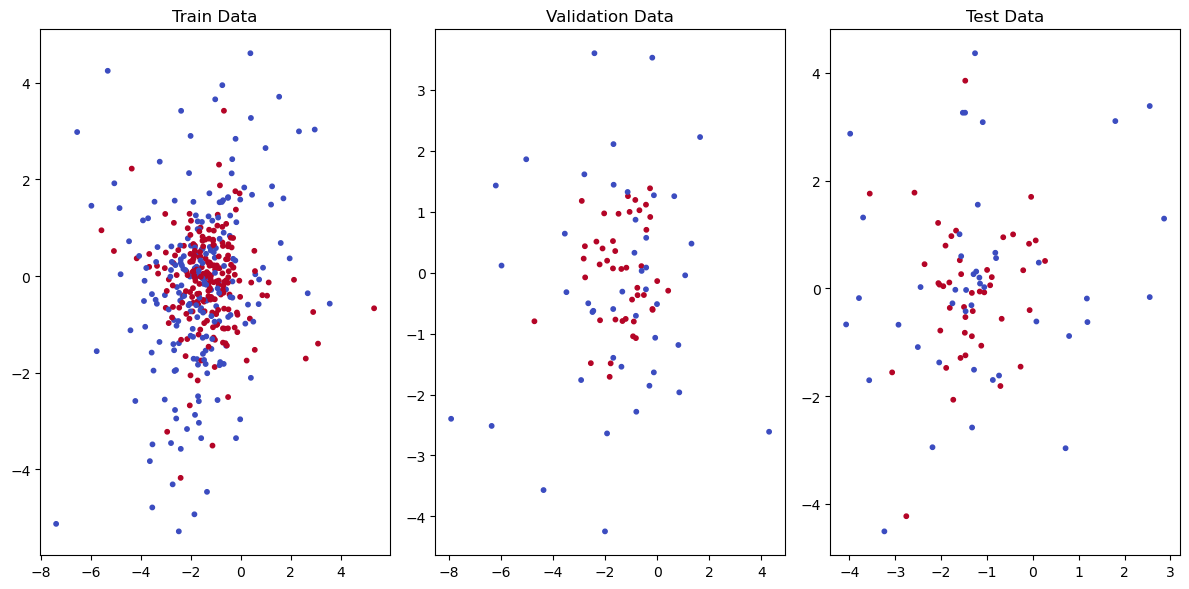

In [67]:

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings)
val_pca = pca.transform(val_embeddings)
test_pca = pca.transform(test_embeddings)

# Remove major outliers for better visualization from PCA and labels
x_mean = np.mean(train_pca[:, 0])
x_std = np.std(train_pca[:, 0])
y_mean = np.mean(train_pca[:, 1])
y_std = np.std(train_pca[:, 1])

# Prune outliers down to 1 standard deviation from the mean
pruned_train_pca = train_pca[(train_pca[:, 0] < x_mean + x_std) & (train_pca[:, 0] > x_mean - x_std) &
                             (train_pca[:, 1] < y_mean + y_std) & (train_pca[:, 1] > y_mean - y_std)]
pruned_train_labels = train_labels[(train_pca[:, 0] < x_mean + x_std) & (train_pca[:, 0] > x_mean - x_std) &
                                   (train_pca[:, 1] < y_mean + y_std) & (train_pca[:, 1] > y_mean - y_std)]

pruned_val_pca = val_pca[(val_pca[:, 0] < x_mean + x_std) & (val_pca[:, 0] > x_mean - x_std) &
                            (val_pca[:, 1] < y_mean + y_std) & (val_pca[:, 1] > y_mean - y_std)]
pruned_val_labels = val_labels[(val_pca[:, 0] < x_mean + x_std) & (val_pca[:, 0] > x_mean - x_std) &
                                (val_pca[:, 1] < y_mean + y_std) & (val_pca[:, 1] > y_mean - y_std)]

pruned_test_pca = test_pca[(test_pca[:, 0] < x_mean + x_std) & (test_pca[:, 0] > x_mean - x_std) &
                            (test_pca[:, 1] < y_mean + y_std) & (test_pca[:, 1] > y_mean - y_std)]
pruned_test_labels = test_labels[(test_pca[:, 0] < x_mean + x_std) & (test_pca[:, 0] > x_mean - x_std) &
                                (test_pca[:, 1] < y_mean + y_std) & (test_pca[:, 1] > y_mean - y_std)]


# Plot PCA embeddings
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(pruned_train_pca[:, 0], pruned_train_pca[:, 1], c=pruned_train_labels, cmap='coolwarm', s=10)
plt.title('Train Data')
plt.subplot(1, 3, 2)
plt.scatter(pruned_val_pca[:, 0], pruned_val_pca[:, 1], c=pruned_val_labels, cmap='coolwarm', s=10)
plt.title('Validation Data')
plt.subplot(1, 3, 3)
plt.scatter(pruned_test_pca[:, 0], pruned_test_pca[:, 1], c=pruned_test_labels, cmap='coolwarm', s=10)
plt.title('Test Data')
plt.tight_layout()
plt.show()



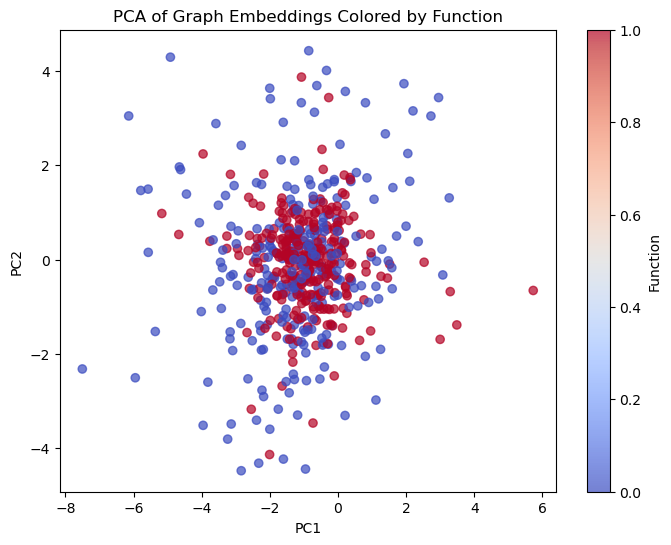

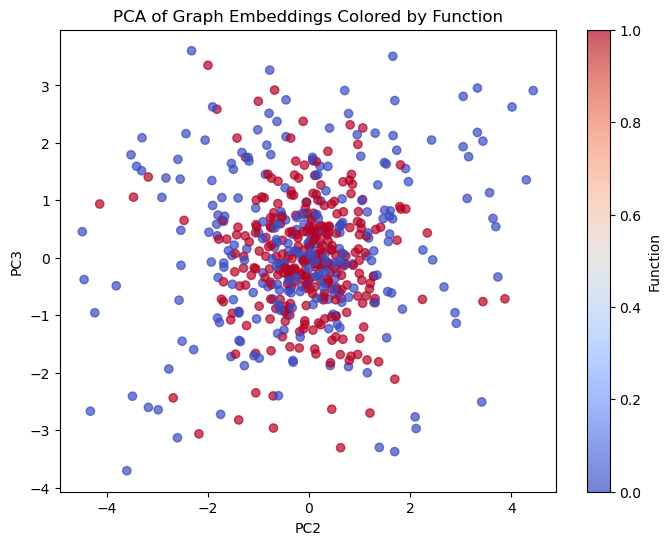

In [68]:
# Perform PCA and plot embeddings
from sklearn.decomposition import PCA

# Combine embeddings and labels
all_embeddings = np.concatenate([train_embeddings, val_embeddings, test_embeddings], axis=0)
all_labels = np.concatenate([train_labels, val_labels, test_labels], axis=0)

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings)

# Prune outliers down to 1 standard deviation from the mean
x_mean = np.mean(pca_result[:, 0])
x_std = np.std(pca_result[:, 0])
y_mean = np.mean(pca_result[:, 1])
y_std = np.std(pca_result[:, 1])
z_mean = np.mean(pca_result[:, 2])
z_std = np.std(pca_result[:, 2])

# Prune outliers down to 1 standard deviation from the mean
pruned_pca_result = pca_result[(pca_result[:, 0] < x_mean + x_std) & (pca_result[:, 0] > x_mean - x_std) &
                               (pca_result[:, 1] < y_mean + y_std) & (pca_result[:, 1] > y_mean - y_std) &
                                 (pca_result[:, 2] < z_mean + z_std) & (pca_result[:, 2] > z_mean - z_std)]
pruned_labels = all_labels[(pca_result[:, 0] < x_mean + x_std) & (pca_result[:, 0] > x_mean - x_std) &
                            (pca_result[:, 1] < y_mean + y_std) & (pca_result[:, 1] > y_mean - y_std) &
                            (pca_result[:, 2] < z_mean + z_std) & (pca_result[:, 2] > z_mean - z_std)]

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pruned_pca_result[:, 0], pruned_pca_result[:, 1], c=pruned_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()

# Also plot PCA2 and PCA3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pruned_pca_result[:, 1], pruned_pca_result[:, 2], c=pruned_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()


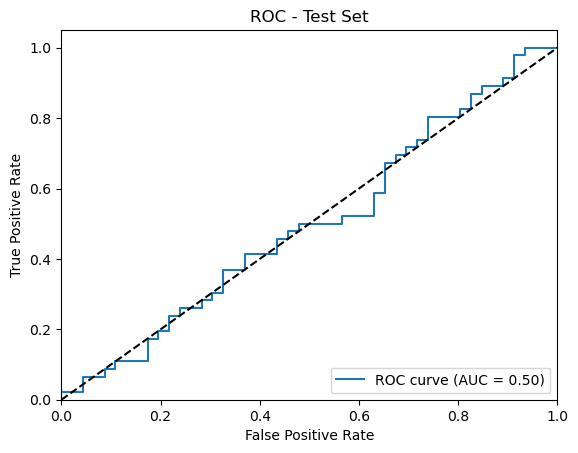

In [69]:
# Train a linear classifier on the embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# Prepare training and test data
X_train = train_embeddings
y_train = train_labels.squeeze()
X_test = test_embeddings
y_test = test_labels.squeeze()

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict probabilities
y_scores = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Test Set')
plt.legend(loc='lower right')
plt.show()


Testing accuracy: 0.6196


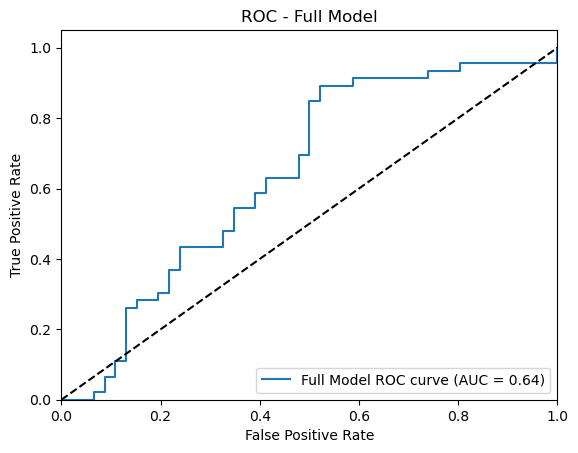

In [70]:
# Evaluate the full model on the test set and plot ROC curve
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out, _ = model(data)
        preds = torch.sigmoid(out).cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

accuracy = get_accuracy(all_preds, all_labels)
print(f"Testing accuracy: {accuracy:.4f}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Full Model ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Full Model')
plt.legend(loc='lower right')
plt.show()


In [71]:
count = 0
for val in all_preds:
    if val > .5:
        #print(val)
        count += 1
#print(preds[0:10])
print(count)
print(len(all_preds))


57
92


# Time to Decode! Using a GraphRNN approach.

In [72]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# For graph operations
from torch_geometric.utils import to_networkx, from_networkx

# For processing
import networkx as nx
import numpy as np

In [73]:
class GraphSequenceDataset(Dataset):
    """
    Dataset class that converts graphs into sequences suitable for GraphRNN,
    and includes corresponding graph embeddings.
    """
    def __init__(self, data_list, embeddings):
        self.graph_sequences = []
        self.embeddings = embeddings
        for idx, data in enumerate(data_list):
            G = to_networkx(data, to_undirected=True)
            seq_nodes, seq_adj = self.graph_to_sequence(G, data)
            graph_embedding = embeddings[idx]
            self.graph_sequences.append((seq_nodes, seq_adj, graph_embedding))

    def graph_to_sequence(self, G, data):
        """
        Converts a NetworkX graph into a sequence of node features and adjacency vectors.
        """
        num_nodes = G.number_of_nodes()
        seq_nodes = []
        seq_adj = []

        # We need a consistent node ordering
        nodes = list(G.nodes())
        node_order = dict(zip(nodes, range(num_nodes)))

        # Node features
        node_features = data.x.numpy()

        for i in range(num_nodes):
            node_idx = nodes[i]
            # Node feature
            node_feat = node_features[node_idx]
            seq_nodes.append(node_feat)

            # Adjacency vector
            adj_vector = np.zeros(i)
            for j in range(i):
                if G.has_edge(node_idx, nodes[j]):
                    adj_vector[j] = 1
            seq_adj.append(adj_vector)

        return seq_nodes, seq_adj

    def __len__(self):
        return len(self.graph_sequences)

    def __getitem__(self, idx):
        seq_nodes, seq_adj, graph_embedding = self.graph_sequences[idx]
        return seq_nodes, seq_adj, graph_embedding


In [74]:
# Ensure embeddings are converted to tensors
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float)

# Prepare the dataset
graph_sequence_dataset = GraphSequenceDataset(train_dataset.data_list, train_embeddings_tensor)

# Define a collate function
def collate_fn(batch):
    seq_nodes, seq_adj, graph_embeddings = zip(*batch)
    return seq_nodes, seq_adj, torch.stack(graph_embeddings)

# DataLoader
graph_sequence_loader = DataLoader(
    graph_sequence_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)


In [75]:
class NodeRNN(nn.Module):
    """
    RNN model for processing node features. 
    """
    def __init__(self, node_feat_size, hidden_size):
        super(NodeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(node_feat_size, hidden_size, batch_first=True)

    def forward(self, node_feats, hidden):
        # node_feats: (batch_size, 1, node_feat_size)
        output, hidden = self.gru(node_feats, hidden)
        return output, hidden

class EdgeRNN(nn.Module):
    """
    RNN model for processing adjacency vectors.
    """
    def __init__(self, hidden_size):
        super(EdgeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(1, hidden_size, batch_first=True)

    def forward(self, adjacency_vector, hidden):
        output, hidden = self.gru(adjacency_vector, hidden)
        return output, hidden



In [76]:
class GraphRNN(nn.Module):
    def __init__(self, node_feat_size, hidden_size, embedding_size):
        super(GraphRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size

        # Embedding layer to map graph embeddings to initial hidden state
        self.embedding_layer = nn.Linear(embedding_size, hidden_size)

        # NodeRNN and EdgeRNN
        self.node_rnn = NodeRNN(node_feat_size, hidden_size)
        self.edge_rnn = EdgeRNN(hidden_size)

        # Output layer for edge predictions
        self.edge_output_layer = nn.Linear(hidden_size, 1)

    def pad_adjacency(self, adj_seq, max_len):
        """ 
        This function pads adjacency vectors to a fixed length.
        This is necessary for batch processing because each graph may have a different number of nodes.
        """
        padded_adj = torch.zeros((max_len, max_len))
        seq_len = len(adj_seq)
        for i in range(seq_len):
            adj_vector = adj_seq[i]
            padded_adj[i, :len(adj_vector)] = torch.tensor(adj_vector, dtype=torch.float)
        return padded_adj

    def forward(self, seq_nodes, seq_adj, graph_embeddings):
        batch_size = len(seq_nodes)
        seq_len = max(len(s) for s in seq_nodes)

        # Initialize hidden state from graph embeddings
        h0 = self.embedding_layer(graph_embeddings).unsqueeze(0)  # (1, batch_size, hidden_size)

        # Pad node feature sequences
        node_feats_padded = nn.utils.rnn.pad_sequence(
            [torch.tensor(s, dtype=torch.float) for s in seq_nodes],
            batch_first=True
        ).to(device)  # (batch_size, seq_len, node_feat_size)

        # Pad adjacency sequences
        adj_padded = [self.pad_adjacency(s, seq_len) for s in seq_adj]
        adj_padded = torch.stack(adj_padded, dim=0).to(device)  # (batch_size, seq_len, seq_len)

        # NodeRNN - This will output node hidden states at each sequence step
        node_outputs, _ = self.node_rnn(node_feats_padded, h0)  # (batch_size, seq_len, hidden_size)

        # EdgeRNN - This will output edge logits for each node at each sequence step
        edge_logits_list = []
        for i in range(seq_len):
            # Get the node hidden state at time step i
            edge_hidden = node_outputs[:, i, :].unsqueeze(0)  # (1, batch_size, hidden_size)
            adj_vectors = adj_padded[:, i, :i+1].unsqueeze(-1)  # (batch_size, i+1, 1)
            edge_output, _ = self.edge_rnn(adj_vectors, edge_hidden)
            edge_logits = self.edge_output_layer(edge_output).squeeze(-1)  # (batch_size, i+1)
            edge_logits_list.append(edge_logits)

        return edge_logits_list, adj_padded



In [77]:
def train_graph_rnn(model, data_loader, optimizer, edge_criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for seq_nodes, seq_adj, graph_embeddings in tqdm(data_loader):
            batch_size = len(seq_nodes)
            optimizer.zero_grad()

            # Move data to device
            graph_embeddings = graph_embeddings.to(device)  # (batch_size, embedding_size)

            # Forward pass
            edge_logits_list, adj_padded = model(seq_nodes, seq_adj, graph_embeddings)

            # Compute loss
            loss = 0
            seq_len = len(edge_logits_list)
            for i in range(seq_len):
                # Prepare target adjacency vector
                adj_targets = adj_padded[:, i, :i+1]  # (batch_size, i+1)
                edge_logits = edge_logits_list[i]  # (batch_size, i+1)

                # Mask padded positions where adj_targets is zero and i >= actual sequence length
                actual_lengths = [len(s) for s in seq_adj]  # Original sequence lengths
                max_len = adj_padded.size(1)
                batch_indices = torch.arange(batch_size).unsqueeze(1).expand(batch_size, max_len).to(device) # maybe usefull?
                time_indices = torch.arange(max_len).unsqueeze(0).expand(batch_size, max_len).to(device) # "time" here is the sequence length

                # Create mask where time index is less than actual length
                mask = time_indices < torch.tensor(actual_lengths).unsqueeze(1).to(device)

                adj_targets = adj_padded[:, i, :i+1]
                edge_logits = edge_logits_list[i]

                mask = mask[:, :i+1]

                if mask.any():
                    loss_step = edge_criterion(edge_logits[mask], adj_targets[mask])
                    loss += loss_step

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


In [ ]:
# Instantiate the model
node_feat_size = train_dataset[0].x.shape[1]  # Assuming all nodes have the same feature size
hidden_size = 64
embedding_size = train_embeddings.shape[1]  # From the HEGNN embeddings

graph_rnn = GraphRNN(node_feat_size, hidden_size, embedding_size).to(device)

# Loss function and optimizer
edge_criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(graph_rnn.parameters(), lr=0.001)

# Train the model
train_graph_rnn(graph_rnn, graph_sequence_loader, optimizer, edge_criterion, epochs=10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:15<00:00,  3.47it/s]


Epoch 1/10, Loss: 28.0505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:15<00:00,  3.45it/s]


Epoch 2/10, Loss: 11.7704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:15<00:00,  3.41it/s]


Epoch 3/10, Loss: 11.3675


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:15<00:00,  3.48it/s]


Epoch 4/10, Loss: 8.7446


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:14<00:00,  3.56it/s]


Epoch 5/10, Loss: 7.3934


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:15<00:00,  3.36it/s]


Epoch 6/10, Loss: 4.0139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:15<00:00,  3.50it/s]


Epoch 7/10, Loss: 2.6501


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:15<00:00,  3.40it/s]


Epoch 8/10, Loss: 1.3999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:15<00:00,  3.39it/s]


Epoch 9/10, Loss: 1.5434


  9%|████████████████▊                                                                                                                                                                 | 5/53 [00:02<00:20,  2.36it/s]

# Woah, it actually trained something. Well, going to try to actually make a molecule now. For science!

In [31]:
# Get positive embeddings
positive_embeddings = train_embeddings[train_labels.squeeze() == 1]

# Calculate centroid
centroid = np.mean(positive_embeddings, axis=0)
centroid = torch.tensor(centroid, dtype=torch.float).to(device)


In [32]:
def generate_graph(model, initial_embedding, max_nodes=20):
    model.eval()
    generated_nodes = []
    generated_adj = []

    # Initialize hidden state
    h0 = model.embedding_layer(initial_embedding.unsqueeze(0))  # Shape: (1, hidden_size)
    h0 = h0.unsqueeze(0)  # Shape: (1, 1, hidden_size)

    # Start NodeRNN generation
    node_hidden = h0
    for i in range(max_nodes):
        # For simplicity, I'm sampling node features from a standard normal distribution
        # might want to change this to sample from a learned distribution or use a specific node type
        node_feat = torch.randn(1, 1, node_feat_size).to(device)
        node_output, node_hidden = model.node_rnn(node_feat, node_hidden) # Right now I'm generating node features from the data, we should probably change this to use real atom features
        generated_nodes.append(node_feat.squeeze(0).cpu().numpy())

        # EdgeRNN generation
        adj_vector = []
        edge_input = torch.zeros(1, 1, 1).to(device)  # Start with zero
        edge_hidden = node_hidden
        for j in range(i+1):
            edge_output, edge_hidden = model.edge_rnn(edge_input, edge_hidden)
            edge_logit = model.edge_output_layer(edge_output)
            edge_prob = torch.sigmoid(edge_logit)
            #print(edge_prob)
            #edge_pred = (edge_prob > 0.25).float() # This is arbitrary, could be improved
            # Instead, use the edge prob as a binomial distribution
            edge_pred = torch.bernoulli(edge_prob)
            adj_vector.append(edge_pred.item())
            edge_input = edge_pred.view(1, 1, 1)

        generated_adj.append(adj_vector)

        # Decide whether to stop (right now I'm not doing EOS, we should probably add this)
        if i > 5 and all(a == 0 for a in adj_vector):
            break  # No new connections, can stop early

    return generated_nodes, generated_adj


In [33]:
def display_generated_graph(generated_graph):
    # Display the generated graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(generated_graph)
    nx.draw(generated_graph, pos, with_labels=True, node_size=500, font_size=10, font_color='white')
    plt.title('Generated Graph')
    plt.show()

    print(generated_graph)


In [34]:
def get_molecule_from_generated_graph(generated_graph: nx.Graph) -> Chem.RWMol:
    """
    Traverses nodes of generated graph to create molecule
    """
    molecule = Chem.RWMol()
    node_to_idx = dict()

    graph_data = generated_graph.nodes.data()
    for node in graph_data: #traverses in order
        node_features_dict = node[1]
        node_features = node_features_dict["features"]
        encoded_atoms = list(node_features[0][0:17])
        max_index = encoded_atoms.index(max(encoded_atoms))

        atomic_number = map_one_hot_to_element[max_index]
        #print(atomic_number)
        atom = Chem.Atom(atomic_number)
        idx = molecule.AddAtom(atom)
        node_to_idx[node[0]] = idx

    for edge in generated_graph.edges():
        node1, node2 = edge
        bond_type = Chem.BondType.SINGLE
        molecule.AddBond(node_to_idx[node1], node_to_idx[node2], bond_type)

    return molecule

In [35]:
def reconstruct_graph(gen_nodes, gen_adj):
        G = nx.Graph()
        num_nodes = len(gen_nodes)
        for i in range(num_nodes):
            G.add_node(i, features=gen_nodes[i])
        for i in range(len(gen_adj)):
            adj_vector = gen_adj[i]
            for j in range(len(adj_vector)):
                if adj_vector[j] == 1:
                    if i != j and not G.has_edge(i, j):
                        G.add_edge(i, j)
        # Prune any isolated nodes - old
        #G.remove_nodes_from(list(nx.isolates(G)))

        #Keep the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
        return G

In [36]:
from rdkit.Chem import Draw
from rdkit.Chem import SanitizeMol, SanitizeFlags

def create_valid_molecule():
    # Sample around the centroid
    sampled_embedding = centroid + torch.randn_like(centroid) * 0.1  # Small perturbation
    molecule = None
    count = 0
    while molecule == None:
        # Generate graph
        gen_nodes, gen_adj = generate_graph(graph_rnn, sampled_embedding)

        # Reconstruct the graph
        generated_graph = reconstruct_graph(gen_nodes, gen_adj)

        #Display generated graph (optional)
        #display_generated_graph(generated_graph)

        generated_mol = get_molecule_from_generated_graph(generated_graph)
        #Not the correct check we want
        #try:
        #    Chem.SanitizeMol(generated_mol, sanitizeOps=SanitizeFlags.SANITIZE_ALL)
        #except ValueError as e:
        #    print(f"Invalid molecule: {e}")
            #continue

        smiles = Chem.MolToSmiles(generated_mol)

        #Need to see if smiles is chemically reasonable
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f'Chemically invalid SMILES: {smiles}')
        else:
            print(f"Valid molecule SMILES: {smiles}")
            molecule = mol
        count += 1

    img = Draw.MolToImage(molecule)
    #img.show()
    print(f"Took {count} tries")

    return mol, smiles

In [37]:
set_of_new_mols = set()
set_of_new_smiles = set()

while len(set_of_new_mols) != 10:
    mol, smiles = create_valid_molecule()
    set_of_new_mols.add(mol)
    set_of_new_smiles.add(smiles)

Valid molecule SMILES: I
Took 1 tries
Valid molecule SMILES: N[SiH2]P
Took 1 tries
Valid molecule SMILES: [SiH4]
Took 1 tries
Chemically invalid SMILES: B12[H]345[AsH]67[BiH]38[As]164I2785
Valid molecule SMILES: S
Took 2 tries
Chemically invalid SMILES: [BiH2]O123456789%10%11%12%13%14%15F%16%17%18%19%20%21%22%23%24%25%26%27%28%29P1%30%31%32%33%34%35%36%37%38%39%40%41%42I%1621%43%44%45%46%47%48%49%50%51%52%53I%17%3032%16%54%55%56%57%58%59%60%61%62B%18%31143%17%30%63%64%65%66%67%68%69%70Br14%18%31%71%72%73%74%75%76N%19%32%43235%77%78%79%80%81%82%83%84%85N1%20%33%44%16%176235%19%32%43%86%87O4%21%34%45%54%30%77716%16%17%20%33%44[Si]%18%22%35%46%55%63%782847%21%30%34%45[Si]%31%23%36%47%56%64%7939128%18%22%35P%71%24%37%48%57%65%805%1064139%23S%72%25%38%49%58%66%81%19%11%1672456S%73%26%39%50%59%67%82%32%12%17%218127[As]%74%27%40%51%60%68%83%43%13%20%30%18341I%75%28%41%52%61%69%84%86%14%33%34%22952[Hg]%76%29%42%53%62%70%85%87%15%44%45%35%23671
Valid molecule SMILES: C1S2345N[Hg]12(N3)([Sn]4)[B

[19:11:13] Explicit valence for atom # 1 H, 5, is greater than permitted
[19:11:13] Explicit valence for atom # 1 O, 17, is greater than permitted
[19:11:13] Explicit valence for atom # 0 O, 4, is greater than permitted
[19:11:13] WARNING: not removing hydrogen atom without neighbors


In [38]:
set_of_new_smiles

{'C1S2345N[Hg]12(N3)([Sn]4)[BiH]5',
 'I',
 'N1[Sn][IH]1',
 'N[SiH2]P',
 'N[SiH](S)[AlH][BiH2]',
 'OP(F)(S)(Cl)I',
 'S',
 '[HH]',
 '[SiH4]'}

# Next Steps: Add new molecules (X amount) to training data, retrain model, test and report scores. Then, improve our code!